In [1]:
import os
import sys

import argparse
import shutil
import time

import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

import matplotlib.pyplot as plt

from pathlib import Path



# Model Specifics
# import pytorch_resnet as R
import BaseModel as B
import CDDSM
from tqdm import tqdm,tqdm_notebook

import logging



#Device Selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 4
learning_rate = 0.001

def pause(strg):
    if(strg!=''):
        print('Reached at {}, Press any key to continue'.format(strg))
    else:
        print('Paused, Press any to continue')
    input()
    return

# x = torch.randn(batch_size, channels_mammo,heights_mammo , width_mammo)

# Reading Standard CSV files by TCIA for test/train

In [13]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'
num_epochs = 100
num_classes = 3
batch_size = 5
learning_rate = 0.0001

total_iteration = 10000
img_resize =H=W=512


homedir = str(Path.home())
homedir

train_df = CDDSM.createTrainFrame(homedir)
test_df = CDDSM.createTestFrame(homedir)
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_file = mammogram_dir+'train.csv'
test_file = mammogram_dir+'test.csv'
train_df.to_csv(train_file)
test_df.to_csv(test_file)

classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')
                

# Making of CBIS-DDSM Dataset (train,val,test)

In [14]:
dataset =  CDDSM.MammographyDataset(train_file,homedir,img_resize)
test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)

train_dataset , val_dataset = CDDSM.trainValSplit(dataset,val_share=0.98)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Length of each Dataset

In [15]:
numberOfTrainData = train_dataset.__len__()
numberOfValData = val_dataset.__len__()
numberOfTestData =  test_dataset.__len__()

total_step=len(train_loader)

print('Size of training dataset {}'.format(numberOfTrainData))
print('Size of Validation dataset {}'.format(numberOfValData))
print('Size of testing dataset {}'.format(numberOfTestData))
print('No. of Epochs: {}\n Batch size: {}\n Learning_rate : {}\n Image size {}*{}\n Step {}'
        .format(num_epochs,batch_size,learning_rate,H,W,total_step))

Size of training dataset 57
Size of Validation dataset 2807
Size of testing dataset 704
No. of Epochs: 100
 Batch size: 5
 Learning_rate : 0.0001
 Image size 512*512
 Step 12


# Checking images in each dataset by making grid

# trainDataset

MALIGNANT BENIGN BENIGN BENIGN_WITHOUT_CALLBACK BENIGN_WITHOUT_CALLBACK


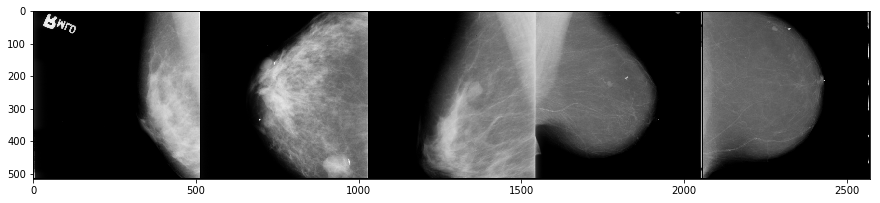

In [16]:
trainloader = train_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    plt.rcParams["figure.figsize"] = [15,12]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# val Dataset

BENIGN MALIGNANT BENIGN BENIGN_WITHOUT_CALLBACK MALIGNANT


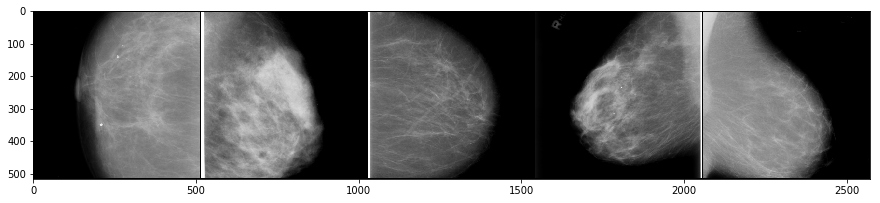

In [17]:
trainloader = val_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [21]:
images

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5686, 0.6745, 0.9216],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.6706, 0.9176],
          [0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.6863, 0.9137],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.7686, 0.9373],
          [0.0000, 0.0000, 0.0000,  ..., 0.5686, 0.8000, 0.9333],
          [0.0000, 0.0000, 0.0000,  ..., 0.5686, 0.7647, 0.9333]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 0.1216, 0.1098, 0.0157],
          [1.0000, 1.0000, 1.0000,  ..., 0.0157, 0.1020, 0.0980],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0902],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..

In [20]:
labels

tensor([0, 2, 0, 1, 2])

# test Dataset

MALIGNANT MALIGNANT


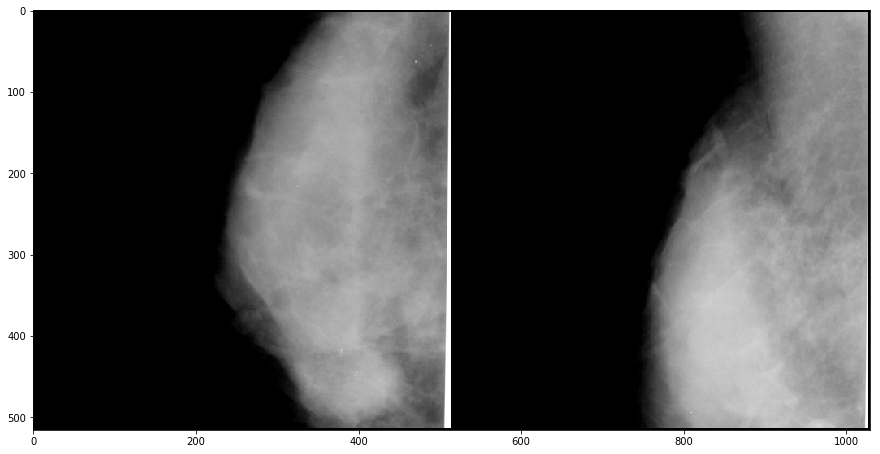

In [7]:
trainloader = test_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Get Model

In [8]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)


# removing last layer of resnet and grad false

resnet = nn.Sequential(*list(resnet.children())[:-1])


for param in resnet.parameters():
    param.requires_grad = False
    
    
class myCustomModel(torch.nn.Module):
    def __init__(self,pretrainedModel):
        super(myCustomModel,self).__init__()
        
        self.layer0 = nn.Sequential()
        self.layer0.add_module('conv0',nn.Conv2d(1,3,kernel_size=9,stride=1,padding=0,dilation=8))
        self.layer0.add_module('relu0',nn.ReLU())
        self.layer0.add_module('maxpool',nn.MaxPool2d(kernel_size=2))
        self.layer1 = nn.Sequential()
        self.layer1.add_module('pretrained',pretrainedModel)
        self.fc = nn.Linear(in_features=512,out_features=3)
    def forward(self,x):
        x = self.layer0(x)
        features = self.layer1(x)
        features = features.view(features.size(0), -1)
        x =  self.fc(features)
        return features , x

def getCustomPretrained(model):
    return myCustomModel(model)
    
    
# parameters with parameters requires grad is True
# for p in resnet18.parameters():
#     print(p.requires_grad)

# model = B.getModel(3).to(device)


In [9]:
# model = B.getModel(3).to(device)
model=getCustomPretrained(resnet)
model=model.to(device)

# store best prediction in one epoch

best_prec = 0


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)


In [10]:
# See the architecture
print(model)

myCustomModel(
  (layer0): Sequential(
    (conv0): Conv2d(1, 3, kernel_size=(9, 9), stride=(1, 1), dilation=(8, 8))
    (relu0): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (pretrained): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0

In [11]:
checkpoint = torch.load('./models/Unfreezemodel_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

myCustomModel(
  (layer0): Sequential(
    (conv0): Conv2d(1, 3, kernel_size=(9, 9), stride=(1, 1), dilation=(8, 8))
    (relu0): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (pretrained): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0

In [12]:
print(criterion)

CrossEntropyLoss()


In [13]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


In [14]:
x = torch.randn(5, 1,512 ,512)

In [15]:
_,y=model(x)
print(y)
# img=y[0].detach().numpy()
# print(img[0])
# plt.imshow(np.transpose(img,(2,1,0)))

tensor([[ 0.3912, -2.0930,  0.9529],
        [ 0.3388, -1.7666,  0.7976],
        [ 0.4152, -2.2141,  1.0079],
        [ 0.3840, -2.0367,  0.9249],
        [ 0.4226, -2.2588,  1.0295]], grad_fn=<ThAddmmBackward>)


# TensorBoard Logger

In [16]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs',comment="baseline")

# Logger

In [17]:
suffix = time.strftime("%d%b%Y%H%M",time.localtime())
logtime = time.strftime("%d%b%Y %H:%M:%S",time.localtime())

level = logging.INFO
format = '%(message)s'
handlers = [logging.FileHandler('Run{}'.format(suffix)),logging.StreamHandler()]
logging.basicConfig(level=level,format=format,handlers=handlers)

In [18]:
def save_checkpoint(state,is_best,filename='./models/checkpoint.pth.tar'):
        torch.save(state,filename)
        if is_best:
            shutil.copyfile(filename,'./models/model_best.pth.tar')

In [19]:
def train(train_loader,model,criterion,optimizer,epoch,writer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()
    
    model.train()
    
    end = time.time()
    for i,(images,labels) in enumerate(train_loader):
        data_time.update(time.time()-end)
        images = images.to(device)
        labels = labels.to(device)
        
        #output = model(images)
        _,output = model(images)
        # for resnet returns features and output
        # print(type(output))
        loss = criterion(output,labels)
        
        # top-k ? accuaracy 
        # for now evaluating normal accuracy
        acc = accuracy(output,labels)
        
        #loss.item() to get the loss value from loss tensor
        losses.update(loss.item(), images.size(0))
        avgaccu.update(acc,images.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        end = time.time()

        print('Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
              'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'.format(
               epoch, i, len(train_loader), batch_time=batch_time,
               data_time=data_time, loss=losses, acc=avgaccu))

In [20]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input=input.to(device)
            target =  target.to(device)
            
            # compute output
            _,output = model(input)
            
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc= accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            avgaccu.update(acc,input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            logging.info('Validation: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.3f} ({acc.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,acc=avgaccu))

        logging.info(' * Acc {acc.avg:.3f}'
              .format(acc=avgaccu))

    return acc

In [21]:
def accuracy(output,target):
    with torch.no_grad():
        batch_size =  target.size(0)
        _, predicted = torch.max(output.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum().item()
        acc = correct/total
    return acc

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def test(test_loader,model):
    count=0
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            print(total)
            images = images.to(device)
            labels = labels.to(device)
            _,outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


In [24]:
def adjust_learning_rate(optimizer,epoch,initLR):
    '''Sets the learning rate to the initial LR decayed by 10 every 30 epoch'''
    lr = initLR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [25]:
test(test_loader,model=model)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526

# Training

In [ ]:

log_freq=10
for epoch in tqdm_notebook(range(num_epochs)):
    
    adjust_learning_rate(optimizer,epoch,learning_rate)
    
    
    train(train_loader,model,criterion,optimizer,epoch+1)
    
    
    
    acc =  validate(val_loader,model,criterion)
    
    
    
    is_best = acc > best_acc
    
    best_acc = max(acc,best_acc)
    
    
    #saving the checkpoint if is_best is True
    save_checkpoint({
        'epoch':epoch+1,
        'state_dict':model.state_dict(),
        'best_acc':best_acc,
        'optimizer':optimizer.state_dict(),
    },is_best)
    
    if(epoch % log_freq==0):
        test(test_loader=test_loader,model=model)
        
test(test_loader,model)